In [94]:
import pandas as pd
from pathlib import Path
import numpy as np
import xarray as xr
from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import setup

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'
meteorological_data_path = data_path/'meteorological_data'
saving_path = data_path/'saved_files'

#### Functions

In [95]:
def read_manning(site):
    """Read Alistair's baseline flags for a given site

    Args:
        site (str): Site code (e.g., MHD)

    Returns:
        pandas.DataFrame: DataFrame with baseline flags (binary)
    """
    
    site_translator = {"MHD": "MH"}

    # Filtering so only including data relevant to the given site
    files = (data_path / "manning_baselines").glob(f"{site_translator[site]}*.txt")

    dfs = []

    # Looping through each of the files for the given site
    for file in files:

        # Read the data, skipping metadata, putting into pandas dataframe
        data = pd.read_csv(file, skiprows=6, delim_whitespace=True)

        # Setting the index of the dataframe to be the extracted datetime and naming it time
        data.index = pd.to_datetime(data['YY'].astype(str) + "-" + \
                                    data['MM'].astype(str) + "-" + \
                                    data['DD'].astype(str) + " " + \
                                    data['HH'].astype(str) + ":00:00")

        data.index.name = "time"
        
        # Adding the 'Ct' column to the previously created empty list
        dfs.append(data[["Ct"]])
    
    # Creating a dataframe from the list containing all the 'Ct' values
    df = pd.concat(dfs)

    df.sort_index(inplace=True)
    
    # Replace all values in Ct column less than 10 or greater than 20 with 0
    # not baseline values
    df.loc[(df['Ct'] < 10) | (df['Ct'] >= 20), 'Ct'] = 0

    # Replace all values between 10 and 19 with 1
    # baseline values
    df.loc[(df['Ct'] >= 10) & (df['Ct'] < 20), 'Ct'] = 1

    # Rename Ct column to "baseline"
    df.rename(columns={'Ct': 'baseline'}, inplace=True)

    return df

In [96]:
def balance_baselines(ds, minority_ratio): 
    """
    Balances the dataset by randomly undersampling non-baseline data points.

    Parameters:
    ds (xarray.Dataset): The dataset to be balanced.
    minority_ratio (float): The desired ratio of baseline (minority class) data points in the final dataset. 
                            For example, 0.4 means 40% of data points will be baseline.

    Returns:
    xarray.Dataset: The balanced dataset where the ratio of baseline to non-baseline data points is as specified by the `minority_ratio` argument.

    Raises:
    ValueError: If the counts of baseline and non-baseline values are not in the expected ratio (within a tolerance of 1%).

    """

    # counting number of baseline&non-baseline data points
    baseline_count = ds['baseline'].where(ds['baseline']==1).count()
    non_baseline_count = ds['baseline'].where(ds['baseline']==0).count()

    # calculating the minority class count (expected to be baseline)
    minority_count = int(min(baseline_count, non_baseline_count))

    # calculating the majority class count based on majority_ratio and minority_count
    majority_ratio = 1 - minority_ratio
    majority_count = int(minority_count * (majority_ratio/minority_ratio))

    # randomly undersampling non-baseline based on majority_count
    np.random.seed(42)
    undersampled_non_baseline = ds.where(ds['baseline'] == 0, drop=True)
    undersampled_non_baseline = undersampled_non_baseline.isel(time=np.random.choice(undersampled_non_baseline.dims['time'], majority_count, replace=False))

    # combining the the undersampled non-baseline with the baseline values
    balanced_ds = xr.merge([ds.where(ds['baseline'] == 1), undersampled_non_baseline])
    balanced_ds = balanced_ds.sortby('time')

    # checking balance
    new_baseline_count = balanced_ds['baseline'].where(balanced_ds['baseline']==1).count()
    new_non_baseline_count = balanced_ds['baseline'].where(balanced_ds['baseline']==0).count()

    # verifying that the ratio of baseline:non-baseline data points is as expected (within a tolerance of 1%)
    tolerance = 0.01
    upper_bound = (1+tolerance)*(majority_ratio/minority_ratio)
    lower_bound = (1-tolerance)*(majority_ratio/minority_ratio)

    if(lower_bound <= (new_non_baseline_count/new_baseline_count) <= upper_bound):
        return balanced_ds
    else:
        raise ValueError("The counts of baseline and non-baseline values are not in the expected ratio.")

#### Defining Site & Compound in Question

In [97]:
site = setup.site
compound = setup.compound

print(f"The compound being explored is {compound}.")

The compound being explored is sf6.


##### Set Up

In [98]:
df = read_manning(site)

ds_flags = df.to_xarray()
balanced_ds_flags = balance_baselines(ds_flags, 0.7)

In [99]:
# Lazy load the NCEP data
# U is the zonal wind component (positive is eastward)
# V is the meridional wind component (positive is northward)

# WIND - SINGULAR DATA POINT
#ds_u = xr.open_mfdataset((data_path/"ncep_singular").glob("*u*.nc")).sel(dict(site=site, level=10))
#ds_v = xr.open_mfdataset((data_path/"ncep_singular").glob("*v*.nc")).sel(dict(site=site, level=10))

# WIND - NINE POINT SYSTEM
ds_u = xr.open_mfdataset((meteorological_data_path/"ncep_9points").glob("*u*.nc")).sel(dict(site=site, level=10))
ds_v = xr.open_mfdataset((meteorological_data_path/"ncep_9points").glob("*v*.nc")).sel(dict(site=site, level=10))

# SURFACE PRESSURE
ds_pres = xr.open_mfdataset((meteorological_data_path/"surface_pressure"/"extracted_data").glob("*.nc")).sel(dict(site=site))

In [100]:
# Grab some AGAGE data 
ds_mf = xr.open_dataset(data_path / f"agage-nc/data-gcms-nc/AGAGE-GCMS-Medusa_{site}_{compound}.nc")

In [101]:
# Create an xarray dataset with the u, v, mole fraction and baseline flags
# ORIGINAL DATASET
ds_uvf = xr.combine_by_coords([ds_u.reindex_like(ds_mf, method="nearest"),
                    ds_v.reindex_like(ds_mf, method="nearest"),
                    ds_pres.reindex_like(ds_mf, method="nearest"),
                    ds_flags.baseline.reindex_like(ds_mf, method="nearest"),
                    ds_mf.mf],
                    combine_attrs="override", coords="minimal", compat="override")

# BALANCED DATASET
ds_uvf_balanced = xr.combine_by_coords([ds_u.reindex_like(ds_mf, method="nearest"),
                    ds_v.reindex_like(ds_mf, method="nearest"),
                    ds_pres.reindex_like(ds_mf, method="nearest"),
                    balanced_ds_flags.baseline.reindex_like(ds_mf, method="nearest"),
                    ds_mf.mf],
                    combine_attrs="override", coords="minimal", compat="override")

# removing associated uwnd/vwnd/mf values associated the removed baseline values (removed for balancing)
# masking values where baseline is NaN
ds_uvf_balanced = ds_uvf_balanced.where(~np.isnan(ds_uvf_balanced['baseline']), drop=True)

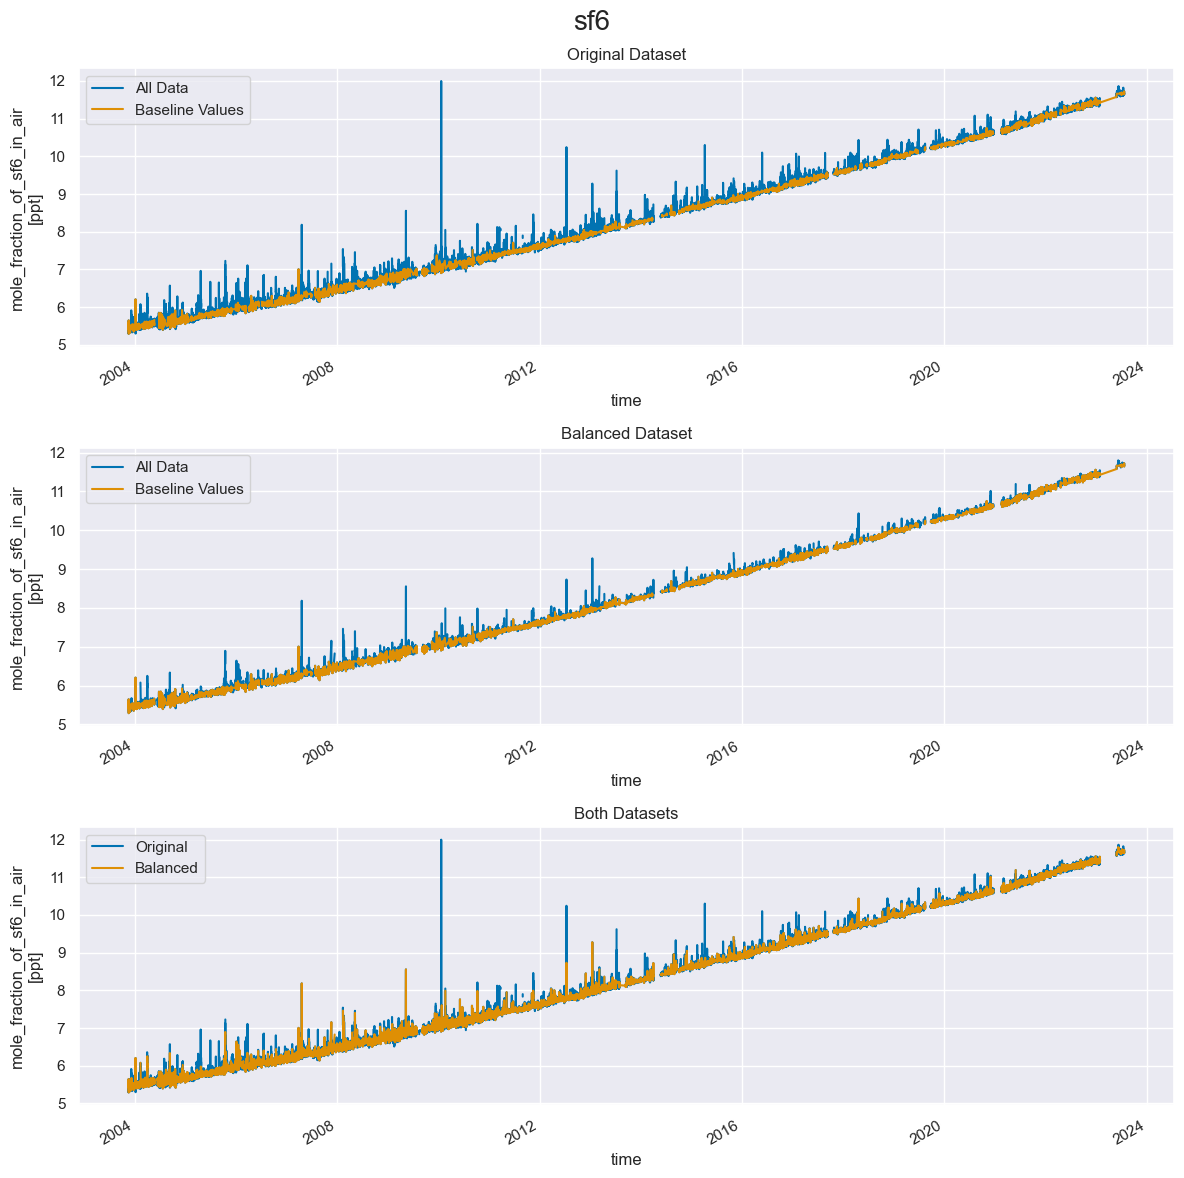

In [102]:
# comparing original and balanced data - no significant data loss
# can I quantify this further?
fig, axs = plt.subplots(3,1, figsize=(12,12))

ds_uvf.mf.plot(ax=axs[0], label="All Data")
ds_uvf.where(ds_uvf.baseline == 1, drop=True).mf.plot(ax=axs[0], label="Baseline Values")
axs[0].set_title("Original Dataset")
axs[0].legend()

ds_uvf_balanced.mf.plot(ax=axs[1], label="All Data")
ds_uvf.where(ds_uvf_balanced.baseline == 1, drop=True).mf.plot(ax=axs[1], label="Baseline Values")
axs[1].set_title("Balanced Dataset")
axs[1].legend()

ds_uvf.mf.plot(ax=axs[2], label="Original")
ds_uvf_balanced.mf.plot(ax=axs[2], label="Balanced")
axs[2].set_title("Both Datasets")
axs[2].legend()

fig.suptitle(f"{compound}", fontsize=20)
fig.set_tight_layout(True)

In [103]:
# Convert to a pandas dataframe - UNBALANCED
df_uvf = pd.DataFrame({"flag": ds_uvf.baseline.values},
                      index=ds_uvf.time.values)


# IF MULTIPLE POINT SYSTEM
for point in ds_uvf.points.values:
    df_uvf[f"u_{point}"] = ds_uvf.uwnd.sel(points=point).values
    df_uvf[f"v_{point}"] = ds_uvf.vwnd.sel(points=point).values


# IF SINGULAR POINT SYSTEM
#df_uvf["u"] = ds_uvf.uwnd.values
#df_uvf["v"] = ds_uvf.vwnd.values   

# surface pressure
df_uvf["pres"] = ds_uvf.pres.values

# Include time of day as another feature (probably doesn't help, but you never know)
df_uvf["time_of_day"] = df_uvf.index.hour

In [104]:
# Convert to a pandas dataframe - BALANCED
df_uvf_balanced = pd.DataFrame({"flag": ds_uvf_balanced.baseline.values},
                      index=ds_uvf_balanced.time.values)


# IF MULTIPLE POINT SYSTEM
for point in ds_uvf_balanced.points.values:
    df_uvf_balanced[f"u_{point}"] = ds_uvf_balanced.uwnd.sel(points=point).values
    df_uvf_balanced[f"v_{point}"] = ds_uvf_balanced.vwnd.sel(points=point).values

# IF SINGULAR POINT SYSTEM
#df_uvf_balanced["u"] = ds_uvf_balanced.uwnd.values
#df_uvf_balanced["v"] = ds_uvf_balanced.vwnd.values 

# surface pressure
df_uvf_balanced["pres"] = ds_uvf_balanced.pres.values  

# TIME VARIABLES
# Time of Day - include for RF, ignore for GBT
df_uvf_balanced["time_of_day"] = df_uvf_balanced.index.hour
# Day of Year
df_uvf_balanced["day_of_year"] = df_uvf_balanced.index.dayofyear

In [105]:
# Save to a CSV file - COMMENT OUT BALANCED/NON BALANCED
# NON BALANCED
#df_uvf.index.name = 'time'
#df_uvf.to_csv('/Users/kirst/Downloads/uvf.csv', index=True)

# BALANCED
df_uvf_balanced.index.name = 'time'
df_uvf_balanced.to_csv('/Users/kirst/Downloads/uvf.csv', index=True)

In [110]:
# saving datasets for evaluation and benchmark analysis
df_uvf_balanced.to_csv(saving_path/'df_uvf_balanced.csv')
ds_uvf_balanced.to_netcdf(saving_path/'ds_uvf_balanced.nc')
ds_mf.to_netcdf(saving_path/'ds_mf.nc')
ds_uvf.to_netcdf(saving_path/'ds_uvf.nc')

In [111]:
df_uvf_balanced.columns

Index(['flag', 'u_0', 'v_0', 'u_1', 'v_1', 'u_2', 'v_2', 'u_3', 'v_3', 'u_4',
       'v_4', 'u_5', 'v_5', 'u_6', 'v_6', 'u_7', 'v_7', 'u_8', 'v_8', 'pres',
       'time_of_day', 'day_of_year'],
      dtype='object')

#### Evaluating & Plotting Model

In [112]:
# making predictions and preparing data
if "predicted_flag" in df_uvf_balanced.columns:
    df_uvf_balanced.drop(columns=["predicted_flag"], inplace=True)

# Load model
rf_model = load('/Users/kirst/Downloads/rf_model.joblib')

# Predict baseline values
df_predict = df_uvf_balanced.copy()
df_predict.drop(columns=["flag"], inplace=True)

print(df_predict.columns)

class_probabilities_predict = rf_model.predict_proba(df_predict.reset_index(drop=True))
threshold = 0.8
y_pred = (class_probabilities_predict[:,1] >= threshold).astype(int)

df_uvf_balanced["predicted_flag"] = y_pred

df_plot = df_uvf_balanced.copy()
df_plot["mf"] = ds_uvf_balanced.mf.values

Index(['u_0', 'v_0', 'u_1', 'v_1', 'u_2', 'v_2', 'u_3', 'v_3', 'u_4', 'v_4',
       'u_5', 'v_5', 'u_6', 'v_6', 'u_7', 'v_7', 'u_8', 'v_8', 'pres',
       'time_of_day', 'day_of_year'],
      dtype='object')


In [113]:
# calculating statistics
actual_values = df_plot["mf"].where((df_plot["flag"] == 1)).dropna()
predicted_values = df_plot["mf"].where(df_plot["predicted_flag"] == 1).dropna()

actual_mean = actual_values.mean()
predicted_mean = predicted_values.mean()

actual_std = actual_values.std()
predicted_std = predicted_values.std()

num_baseline = df_plot["predicted_flag"].where(df_plot["predicted_flag"] == 1).count()
num_not_baseline = df_plot["predicted_flag"].where(df_plot["predicted_flag"] == 0).count()

print(f'Actual Mean: {actual_mean:.3f}, Predicted Mean: {predicted_mean:.3f}')
print(f'Actual Std Dev: {actual_std:.3f}, Predicted Std Dev: {predicted_std:.3f}')
print(f'Number of predicted baseline values: {num_baseline}, Number of predicted non-baseline values: {num_not_baseline}')

Actual Mean: 8.106, Predicted Mean: 8.138
Actual Std Dev: 1.747, Predicted Std Dev: 1.662
Number of predicted baseline values: 5151, Number of predicted non-baseline values: 17869


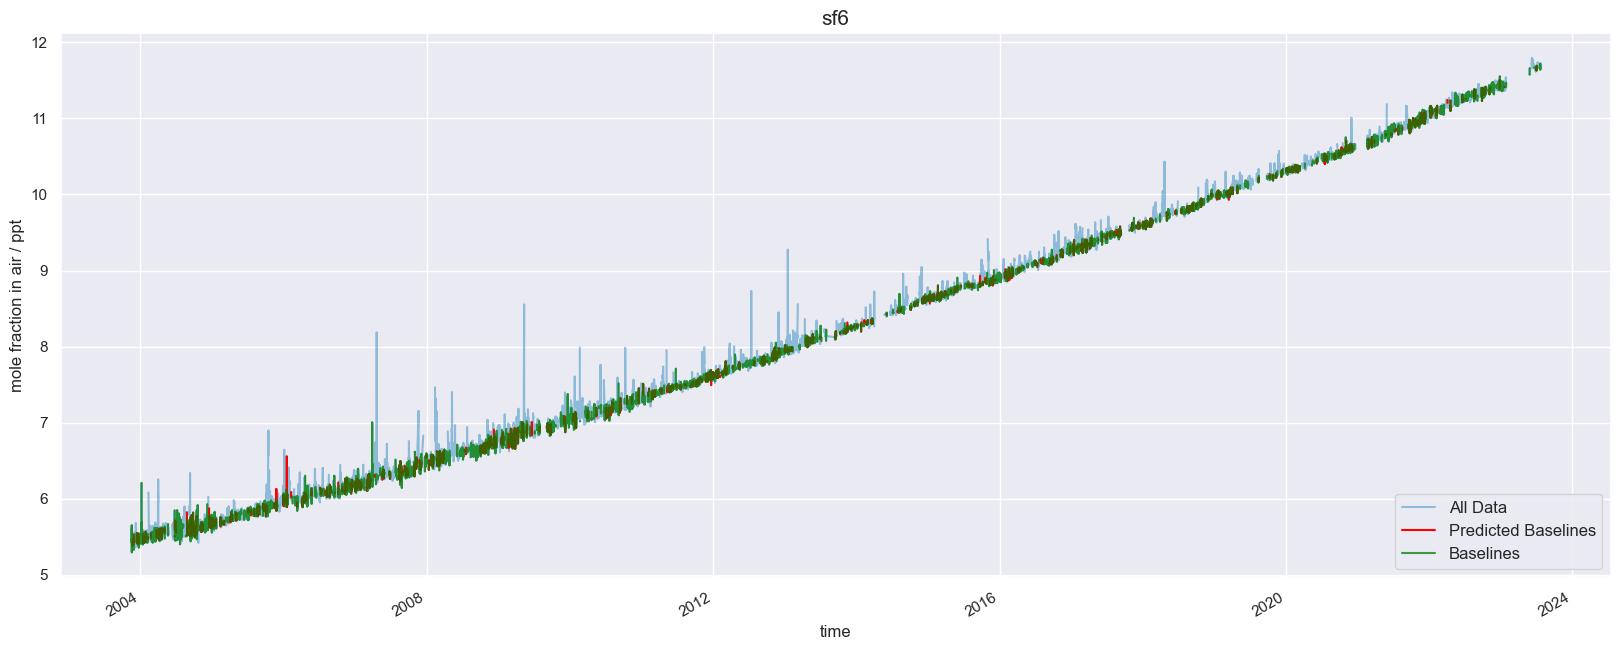

In [114]:
# TIME V MOLE FRACTION PLOT
fig, ax = plt.subplots(figsize=(20,8))
sns.set(style='darkgrid')
sns.set_palette("colorblind")

df_plot["mf"].plot(ax=ax, label="All Data", alpha=0.4)
df_plot["mf"].where(df_plot["predicted_flag"] == 1).plot(ax=ax, label="Predicted Baselines", color='red')
df_plot["mf"].where(df_plot["flag"] == 1).plot(ax=ax, label="Baselines", color='green', alpha=0.75)

# limits to view certain dates if wanted
#plt.xlim(datetime.datetime(2016, 1, 1), datetime.datetime(2022, 12, 31))
#plt.ylim(0, 3)

plt.ylabel("mole fraction in air / ppt")
plt.title(f"{compound}", fontsize=15)
plt.legend(loc="lower right", fontsize=12)

In [115]:
'''

# TIME V MONTHLY AVERAGE MOLE FRACTION PLOT
# extracting flags and predicted flags
df_pred = df_plot.where(df_plot["predicted_flag"] == 1).dropna()
df_actual = df_plot.where(df_plot["flag"] == 1).dropna()

save = 'no'
if save == 'yes':
    df_save_pred = df_pred.drop(columns=["u_0", "v_0", "pres", "time_of_day", "day_of_year", "u_1", "v_1", "u_2", "v_2", 
                                "u_3", "v_3", "u_4", "v_4", "u_5", "v_5", "u_6", "v_6", "u_7", "v_7", "u_8", "v_8"])
    df_save_actual = df_actual.drop(columns=["u_0", "v_0", "pres", "time_of_day", "day_of_year", "u_1", "v_1", "u_2", "v_2", 
                                "u_3", "v_3", "u_4", "v_4", "u_5", "v_5", "u_6", "v_6", "u_7", "v_7", "u_8", "v_8"])

    df_save_pred.to_csv('/Users/kirst/Downloads/df_pred.csv', index=True)
    df_save_actual.to_csv('/Users/kirst/Downloads/df_actual.csv', index=True)

# resampling to monthly averages
df_pred_monthly = df_pred.resample('M').mean()
df_actual_monthly = df_actual.resample('M').mean()
# setting index to year and month only
df_pred_monthly.index = df_pred_monthly.index.to_period('M')
df_actual_monthly.index = df_actual_monthly.index.to_period('M')

# calculating standard deviation
std_pred_monthly = df_pred.groupby(df_pred.index.to_period('M'))["mf"].std().reset_index()
std_pred_monthly.set_index('time', inplace=True)
std_actual_monthly = df_actual.groupby(df_actual.index.to_period('M'))["mf"].std().reset_index()
std_actual_monthly.set_index('time', inplace=True)


# plotting
fig, ax = plt.subplots(figsize=(20,8))
sns.set(style='darkgrid')
sns.set_palette("colorblind")

df_actual_monthly["mf"].plot(ax=ax, label="Baselines", color='green', alpha=0.75)
df_pred_monthly["mf"].plot(ax=ax, label="Predicted Baselines", color='red')

# adding standard deviation shading
upper_actual = df_actual_monthly["mf"] + std_actual_monthly['mf']
lower_actual = df_actual_monthly["mf"] - std_actual_monthly['mf']

ax.fill_between(df_actual_monthly.index, lower_actual, upper_actual, color='green', alpha=0.2, label="Baseline Standard Deviation")

upper_pred = df_pred_monthly["mf"] + std_pred_monthly['mf']
lower_pred = df_pred_monthly["mf"] - std_pred_monthly['mf']
ax.fill_between(df_pred_monthly.index, lower_pred, upper_pred, color='red', alpha=0.2, label="Predicted Baseline Standard Deviation")


# tolerance calculation
tolerances = ["3std", "10%"]
tolerance = tolerances[0]

if tolerance == "3std":
    # 3 standard deviations
    upper_range = df_actual_monthly["mf"] + 3*(std_actual_monthly['mf'])
    lower_range = df_actual_monthly["mf"] - 3*(std_actual_monthly['mf'])
elif tolerance == "10%":
    # plus/minus 10%
    upper_range = df_actual_monthly["mf"] + (0.1*df_actual_monthly["mf"])
    lower_range = df_actual_monthly["mf"] - (0.1*df_actual_monthly["mf"])


# calculating overall standard deviation for arrows
overall_std = df_actual_monthly["mf"].std()

# adding labels to points outside tolerance range
for i in range(len(df_actual_monthly)):
    if df_pred_monthly["mf"].iloc[i] >= upper_range.iloc[i]:
        arrow_end = df_pred_monthly["mf"].iloc[i] + (0.5*overall_std)
        ax.annotate(df_pred_monthly.index[i].strftime('%B %Y'), 
                    xy=(df_pred_monthly.index[i], df_pred_monthly["mf"].iloc[i]), 
                    xytext=(df_pred_monthly.index[i], arrow_end), 
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    horizontalalignment='center', verticalalignment='bottom')
    
    elif df_pred_monthly["mf"].iloc[i] <= lower_range.iloc[i]:
        arrow_end = df_pred_monthly["mf"].iloc[i] - (0.5*overall_std)
        ax.annotate(df_pred_monthly.index[i].strftime('%B %Y'), 
                    xy=(df_pred_monthly.index[i], df_pred_monthly["mf"].iloc[i]), 
                    xytext=(df_pred_monthly.index[i], arrow_end), 
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    horizontalalignment='center', verticalalignment='bottom')
        

# limits to view certain dates if wanted
#plt.xlim(datetime.datetime(2012, 1, 1), datetime.datetime(2023, 12, 31))
#plt.ylim(0, 3)

plt.ylabel("mole fraction in air / ppt")
plt.title(f"{compound}", fontsize=15)
plt.legend(loc="lower right", fontsize=12)
'''

'\n\n# TIME V MONTHLY AVERAGE MOLE FRACTION PLOT\n# extracting flags and predicted flags\ndf_pred = df_plot.where(df_plot["predicted_flag"] == 1).dropna()\ndf_actual = df_plot.where(df_plot["flag"] == 1).dropna()\n\nsave = \'no\'\nif save == \'yes\':\n    df_save_pred = df_pred.drop(columns=["u_0", "v_0", "pres", "time_of_day", "day_of_year", "u_1", "v_1", "u_2", "v_2", \n                                "u_3", "v_3", "u_4", "v_4", "u_5", "v_5", "u_6", "v_6", "u_7", "v_7", "u_8", "v_8"])\n    df_save_actual = df_actual.drop(columns=["u_0", "v_0", "pres", "time_of_day", "day_of_year", "u_1", "v_1", "u_2", "v_2", \n                                "u_3", "v_3", "u_4", "v_4", "u_5", "v_5", "u_6", "v_6", "u_7", "v_7", "u_8", "v_8"])\n\n    df_save_pred.to_csv(\'/Users/kirst/Downloads/df_pred.csv\', index=True)\n    df_save_actual.to_csv(\'/Users/kirst/Downloads/df_actual.csv\', index=True)\n\n# resampling to monthly averages\ndf_pred_monthly = df_pred.resample(\'M\').mean()\ndf_actual_monthl

##### Plotting Anomalous Months - 10% tolerance

In [116]:
# hfc-152a
if compound == "hfc-152a":
    fig, axs = plt.subplots(2,2, figsize=(20,10))
    sns.set(style='darkgrid')
    sns.set_palette("colorblind")

    # January 2006
    jan_2006 = df_plot.loc['2006-01-01':'2006-01-31']
    # calculating some stats
    pred_mean = jan_2006["mf"].where(jan_2006["predicted_flag"] == 1).mean()
    actual_mean = jan_2006["mf"].where(jan_2006["flag"] == 1).mean()
    pred_count = jan_2006["mf"].where(jan_2006["predicted_flag"] == 1).count()
    actual_count = jan_2006["mf"].where(jan_2006["flag"] == 1).count()

    # plotting baseline points
    axs[0,0].scatter(jan_2006.index, jan_2006["mf"].where(jan_2006["flag"] == 1), 
                   color='green', label=f"Baselines (count={actual_count})", marker='x', s=75)
    axs[0,0].scatter(jan_2006.index, jan_2006["mf"].where(jan_2006["predicted_flag"] == 1), 
                   color='red', label=f"Predicted Baselines (count={pred_count})", marker='x', s=75)
    # plotting mean lines
    axs[0,0].axhline(y=actual_mean, color='green', linestyle='-', label='Actual Mean')
    axs[0,0].axhline(y=pred_mean, color='red', linestyle='--', label='Predicted Mean')  

    axs[0,0].set_ylabel("mole fraction in air / ppt")
    axs[0,0].set_title("January 2006", fontsize=20)
    axs[0,0].legend(fontsize=14)

    # comparing counts
    counts = []
    true_positive_count = jan_2006["mf"].where((jan_2006["predicted_flag"] == 1) & (jan_2006["flag"] == 1)).count()
    false_postive_count = jan_2006["mf"].where((jan_2006["predicted_flag"] == 1) & (jan_2006["flag"] == 0)).count()
    true_negative_count = jan_2006["mf"].where((jan_2006["predicted_flag"] == 0) & (jan_2006["flag"] == 0)).count()
    false_negative_count = jan_2006["mf"].where((jan_2006["predicted_flag"] == 0) & (jan_2006["flag"] == 1)).count()
    counts.append(true_positive_count)
    counts.append(false_postive_count)
    counts.append(true_negative_count)
    counts.append(false_negative_count)

    axs[1,0].bar(["True Positive", "False Positive", "True Negative", "False Negative"], counts, color='grey')

    for i in range(len(counts)):
        percentage = counts[i] / jan_2006["mf"].count() * 100
        axs[1,0].text(i, counts[i], f"{counts[i]} ({percentage:.1f}%)", fontsize=10, ha='center', va='bottom')


    # August 2008
    aug_2008 = df_plot.loc['2008-08-01':'2008-08-31']

    pred_mean = aug_2008["mf"].where(aug_2008["predicted_flag"] == 1).mean()
    actual_mean = aug_2008["mf"].where(aug_2008["flag"] == 1).mean()
    pred_count = aug_2008["mf"].where(aug_2008["predicted_flag"] == 1).count()
    actual_count = aug_2008["mf"].where(aug_2008["flag"] == 1).count()

    axs[0,1].scatter(aug_2008.index, aug_2008["mf"].where(aug_2008["flag"] == 1), 
                   color='green', label=f"Baselines (count={actual_count})", marker='x', s=75)
    axs[0,1].scatter(aug_2008.index, aug_2008["mf"].where(aug_2008["predicted_flag"] == 1), 
                   color='red', label=f"Predicted Baselines (count={pred_count})", marker='x', s=75)

    axs[0,1].axhline(y=actual_mean, color='green', linestyle='-', label='Actual Mean')
    axs[0,1].axhline(y=pred_mean, color='red', linestyle='--', label='Predicted Mean')  

    axs[0,1].set_ylabel("mole fraction in air / ppt")
    axs[0,1].set_title("August 2008", fontsize=20)
    axs[0,1].legend(fontsize=14)

    counts = []
    true_positive_count = aug_2008["mf"].where((aug_2008["predicted_flag"] == 1) & (aug_2008["flag"] == 1)).count()
    false_postive_count = aug_2008["mf"].where((aug_2008["predicted_flag"] == 1) & (aug_2008["flag"] == 0)).count()
    true_negative_count = aug_2008["mf"].where((aug_2008["predicted_flag"] == 0) & (aug_2008["flag"] == 0)).count()
    false_negative_count = aug_2008["mf"].where((aug_2008["predicted_flag"] == 0) & (aug_2008["flag"] == 1)).count()
    counts.append(true_positive_count)
    counts.append(false_postive_count)
    counts.append(true_negative_count)
    counts.append(false_negative_count)

    axs[1,1].bar(["True Positive", "False Positive", "True Negative", "False Negative"], counts, color='grey')

    for i in range(len(counts)):
        percentage = counts[i] / jan_2006["mf"].count() * 100
        axs[1,1].text(i, counts[i], f"{counts[i]} ({percentage:.1f}%)", fontsize=10, ha='center', va='bottom')


    fig.suptitle("HFC-152a", fontsize=25)
    fig.set_tight_layout(True)

In [117]:
# hfc-32
if compound == "hfc-32":
    fig, axs = plt.subplots(4,2, figsize=(20,15))
    sns.set(style='darkgrid')
    sns.set_palette("colorblind")

    # March 2013
    march_2013 = df_plot.loc['2013-03-01':'2013-03-31']
    # calculating some stats
    pred_mean = march_2013["mf"].where(march_2013["predicted_flag"] == 1).mean()
    actual_mean = march_2013["mf"].where(march_2013["flag"] == 1).mean()
    pred_count = march_2013["mf"].where(march_2013["predicted_flag"] == 1).count()
    actual_count = march_2013["mf"].where(march_2013["flag"] == 1).count()
    # plotting baseline points
    axs[0,0].scatter(march_2013.index, march_2013["mf"].where(march_2013["flag"] == 1), 
                   color='green', label=f"Baselines (count={actual_count})", marker='x', s=75)
    axs[0,0].scatter(march_2013.index, march_2013["mf"].where(march_2013["predicted_flag"] == 1), 
                   color='red', label=f"Predicted Baselines (count={pred_count})", marker='x', s=75)
    # plotting mean lines
    axs[0,0].axhline(y=actual_mean, color='green', linestyle='-', label='Actual Mean')
    axs[0,0].axhline(y=pred_mean, color='red', linestyle='--', label='Predicted Mean')  

    axs[0,0].set_ylabel("mole fraction in air / ppt")
    axs[0,0].set_title("March 2013", fontsize=20)
    axs[0,0].legend(fontsize=14)

    # comparing counts
    counts = []
    true_positive_count = march_2013["mf"].where((march_2013["predicted_flag"] == 1) & (march_2013["flag"] == 1)).count()
    false_postive_count = march_2013["mf"].where((march_2013["predicted_flag"] == 1) & (march_2013["flag"] == 0)).count()
    true_negative_count = march_2013["mf"].where((march_2013["predicted_flag"] == 0) & (march_2013["flag"] == 0)).count()
    false_negative_count = march_2013["mf"].where((march_2013["predicted_flag"] == 0) & (march_2013["flag"] == 1)).count()
    counts.append(true_positive_count)
    counts.append(false_postive_count)
    counts.append(true_negative_count)
    counts.append(false_negative_count)

    axs[1,0].bar(["True Positive", "False Positive", "True Negative", "False Negative"], counts, color='grey')
    for i in range(len(counts)):
        percentage = counts[i] / march_2013["mf"].count() * 100
        axs[1,0].text(i, counts[i], f"{counts[i]} ({percentage:.1f}%)", fontsize=10, ha='center', va='bottom')


    # October 2013
    oct_2013 = df_plot.loc['2013-10-01':'2013-10-31']

    pred_mean = oct_2013["mf"].where(oct_2013["predicted_flag"] == 1).mean()
    actual_mean = oct_2013["mf"].where(oct_2013["flag"] == 1).mean()
    pred_count = oct_2013["mf"].where(oct_2013["predicted_flag"] == 1).count()
    actual_count = oct_2013["mf"].where(oct_2013["flag"] == 1).count()

    axs[0,1].scatter(oct_2013.index, oct_2013["mf"].where(oct_2013["flag"] == 1), 
                   color='green', label=f"Baselines (count={actual_count})", marker='x', s=75)
    axs[0,1].scatter(oct_2013.index, oct_2013["mf"].where(oct_2013["predicted_flag"] == 1), 
                   color='red', label=f"Predicted Baselines (count={pred_count})", marker='x', s=75)

    axs[0,1].axhline(y=actual_mean, color='green', linestyle='-', label='Actual Mean')
    axs[0,1].axhline(y=pred_mean, color='red', linestyle='--', label='Predicted Mean')  

    axs[0,1].set_ylabel("mole fraction in air / ppt")
    axs[0,1].set_title("October 2013", fontsize=20)
    axs[0,1].legend(fontsize=14)

    counts = []
    true_positive_count = oct_2013["mf"].where((oct_2013["predicted_flag"] == 1) & (oct_2013["flag"] == 1)).count()
    false_postive_count = oct_2013["mf"].where((oct_2013["predicted_flag"] == 1) & (oct_2013["flag"] == 0)).count()
    true_negative_count = oct_2013["mf"].where((oct_2013["predicted_flag"] == 0) & (oct_2013["flag"] == 0)).count()
    false_negative_count = oct_2013["mf"].where((oct_2013["predicted_flag"] == 0) & (oct_2013["flag"] == 1)).count()
    counts.append(true_positive_count)
    counts.append(false_postive_count)
    counts.append(true_negative_count)
    counts.append(false_negative_count)

    axs[1,1].bar(["True Positive", "False Positive", "True Negative", "False Negative"], counts, color='grey')
    for i in range(len(counts)):
        percentage = counts[i] / oct_2013["mf"].count() * 100
        axs[1,1].text(i, counts[i], f"{counts[i]} ({percentage:.1f}%)", fontsize=10, ha='center', va='bottom')


    fig.suptitle("HFC-32", fontsize=25)
    fig.set_tight_layout(True)

##### Plotting Anomalous Months - 3 standard deviation tolerance

In [118]:
# hfc-125
if compound == "hfc-125":
    fig, axs = plt.subplots(4,2, figsize=(20,25))
    sns.set(style='darkgrid')
    sns.set_palette("colorblind")


    anomalies_125 = ['2007-04-01', '2007-04-30', 
                    '2008-08-01', '2008-08-31', 
                    '2010-09-01', '2010-09-30', 
                    '2021-08-01', '2021-08-31']

    for n in range(0, int(len(anomalies_125)/2)):
        start, end = anomalies_125[2*n], anomalies_125[2*n+1]
        month = df_plot.loc[start:end]
        # calculating some stats
        pred_mean = month["mf"].where(month["predicted_flag"] == 1).mean()
        actual_mean = month["mf"].where(month["flag"] == 1).mean()
        pred_count = month["mf"].where(month["predicted_flag"] == 1).count()
        actual_count = month["mf"].where(month["flag"] == 1).count()

        # plotting baseline points
        axs[n,0].scatter(month.index, month["mf"].where(month["flag"] == 1), 
                       color='green', label=f"Baselines (count={actual_count})", marker='x', s=75)
        axs[n,0].scatter(month.index, month["mf"].where(month["predicted_flag"] == 1), 
                       color='red', label=f"Predicted Baselines (count={pred_count})", marker='x', s=75)
        # plotting mean lines
        axs[n,0].axhline(y=actual_mean, color='green', linestyle='-', label='Actual Mean')
        axs[n,0].axhline(y=pred_mean, color='red', linestyle='--', label='Predicted Mean')

        # adding tolerance limit line
        actual_std = month["mf"].where(month["flag"] == 1).std()
        tolerance_limit = actual_mean + (3*actual_std)
        axs[n,0].axhline(y=tolerance_limit, color='blue', linestyle='-', label='Tolerance Limit', alpha=0.5) 

        # formatting plot
        start_date = datetime.strptime(start, '%Y-%m-%d')
        formatted_date = start_date.strftime('%b %Y')
        axs[n,0].set_title(f"{formatted_date}", fontsize=20)
    
        axs[n,0].set_ylabel("mole fraction in air / ppt")
        axs[n,0].legend(fontsize=14)


        # comparing counts
        counts = []
        true_positive_count = month["mf"].where((month["predicted_flag"] == 1) & (month["flag"] == 1)).count()
        false_postive_count = month["mf"].where((month["predicted_flag"] == 1) & (month["flag"] == 0)).count()
        true_negative_count = month["mf"].where((month["predicted_flag"] == 0) & (month["flag"] == 0)).count()
        false_negative_count = month["mf"].where((month["predicted_flag"] == 0) & (month["flag"] == 1)).count()
        counts.append(true_positive_count)
        counts.append(false_postive_count)
        counts.append(true_negative_count)
        counts.append(false_negative_count)

        axs[n,1].bar(["True Positive", "False Positive", "True Negative", "False Negative"], counts, color='grey')

        for i in range(len(counts)):
            percentage = counts[i] / month["mf"].count() * 100
            axs[n,1].text(i, counts[i], f"{counts[i]} ({percentage:.1f}%)", fontsize=10, ha='center', va='bottom')


fig.suptitle("HFC-125", fontsize=25)
fig.set_tight_layout(True)

In [119]:
# hfc-134a
if compound == "hfc-134a":
    fig, axs = plt.subplots(6,2, figsize=(20,30))
    sns.set(style='darkgrid')
    sns.set_palette("colorblind")


    anomalies_134a = ['2007-04-01', '2007-04-30', 
                    '2008-06-01', '2008-06-30', 
                    '2008-08-01', '2008-08-31', 
                    '2012-08-01', '2012-08-31',
                    '2018-06-01', '2018-06-30',
                    '2021-08-01', '2021-08-31']

    for n in range(0, int(len(anomalies_134a)/2)):
        start, end = anomalies_134a[2*n], anomalies_134a[2*n+1]
        month = df_plot.loc[start:end]
        # calculating some stats
        pred_mean = month["mf"].where(month["predicted_flag"] == 1).mean()
        actual_mean = month["mf"].where(month["flag"] == 1).mean()
        pred_count = month["mf"].where(month["predicted_flag"] == 1).count()
        actual_count = month["mf"].where(month["flag"] == 1).count()

        # plotting baseline points
        axs[n,0].scatter(month.index, month["mf"].where(month["flag"] == 1), 
                       color='green', label=f"Baselines (count={actual_count})", marker='x', s=75)
        axs[n,0].scatter(month.index, month["mf"].where(month["predicted_flag"] == 1), 
                       color='red', label=f"Predicted Baselines (count={pred_count})", marker='x', s=75)
        # plotting mean lines
        axs[n,0].axhline(y=actual_mean, color='green', linestyle='-', label='Actual Mean')
        axs[n,0].axhline(y=pred_mean, color='red', linestyle='--', label='Predicted Mean') 

        # adding tolerance limit line
        actual_std = month["mf"].where(month["flag"] == 1).std()
        tolerance_limit = actual_mean + (3*actual_std)
        axs[n,0].axhline(y=tolerance_limit, color='blue', linestyle='-', label='Tolerance Limit', alpha=0.5)

        # formatting plot
        start_date = datetime.strptime(start, '%Y-%m-%d')
        formatted_date = start_date.strftime('%b %Y')
        axs[n,0].set_title(f"{formatted_date}", fontsize=20)
    
        axs[n,0].set_ylabel("mole fraction in air / ppt")
        axs[n,0].legend(fontsize=14)


        # comparing counts
        counts = []
        true_positive_count = month["mf"].where((month["predicted_flag"] == 1) & (month["flag"] == 1)).count()
        false_postive_count = month["mf"].where((month["predicted_flag"] == 1) & (month["flag"] == 0)).count()
        true_negative_count = month["mf"].where((month["predicted_flag"] == 0) & (month["flag"] == 0)).count()
        false_negative_count = month["mf"].where((month["predicted_flag"] == 0) & (month["flag"] == 1)).count()
        counts.append(true_positive_count)
        counts.append(false_postive_count)
        counts.append(true_negative_count)
        counts.append(false_negative_count)

        axs[n,1].bar(["True Positive", "False Positive", "True Negative", "False Negative"], counts, color='grey')

        for i in range(len(counts)):
            percentage = counts[i] / month["mf"].count() * 100
            axs[n,1].text(i, counts[i], f"{counts[i]} ({percentage:.1f}%)", fontsize=10, ha='center', va='bottom')


fig.suptitle("HFC-134a", fontsize=25)
fig.set_tight_layout(True)

In [120]:
# hfc-143a
if compound == "hfc-143a":
    fig, axs = plt.subplots(2,2, figsize=(20,10))
    sns.set(style='darkgrid')
    sns.set_palette("colorblind")


    anomalies_134a = ['2007-04-01', '2007-04-30', 
                      '2008-08-01', '2008-08-31',]

    for n in range(0, int(len(anomalies_134a)/2)):
        start, end = anomalies_134a[2*n], anomalies_134a[2*n+1]
        month = df_plot.loc[start:end]
        # calculating some stats
        pred_mean = month["mf"].where(month["predicted_flag"] == 1).mean()
        actual_mean = month["mf"].where(month["flag"] == 1).mean()
        pred_count = month["mf"].where(month["predicted_flag"] == 1).count()
        actual_count = month["mf"].where(month["flag"] == 1).count()

        # plotting baseline points
        axs[n,0].scatter(month.index, month["mf"].where(month["flag"] == 1), 
                       color='green', label=f"Baselines (count={actual_count})", marker='x', s=75)
        axs[n,0].scatter(month.index, month["mf"].where(month["predicted_flag"] == 1), 
                       color='red', label=f"Predicted Baselines (count={pred_count})", marker='x', s=75)
        # plotting mean lines
        axs[n,0].axhline(y=actual_mean, color='green', linestyle='-', label='Actual Mean')
        axs[n,0].axhline(y=pred_mean, color='red', linestyle='--', label='Predicted Mean') 

        # adding tolerance limit line
        actual_std = month["mf"].where(month["flag"] == 1).std()
        tolerance_limit = actual_mean + (3*actual_std)
        axs[n,0].axhline(y=tolerance_limit, color='blue', linestyle='-', label='Tolerance Limit', alpha=0.5)

        # formatting plot
        start_date = datetime.strptime(start, '%Y-%m-%d')
        formatted_date = start_date.strftime('%b %Y')
        axs[n,0].set_title(f"{formatted_date}", fontsize=20)
    
        axs[n,0].set_ylabel("mole fraction in air / ppt")
        axs[n,0].legend(fontsize=14)


        # comparing counts
        counts = []
        true_positive_count = month["mf"].where((month["predicted_flag"] == 1) & (month["flag"] == 1)).count()
        false_postive_count = month["mf"].where((month["predicted_flag"] == 1) & (month["flag"] == 0)).count()
        true_negative_count = month["mf"].where((month["predicted_flag"] == 0) & (month["flag"] == 0)).count()
        false_negative_count = month["mf"].where((month["predicted_flag"] == 0) & (month["flag"] == 1)).count()
        counts.append(true_positive_count)
        counts.append(false_postive_count)
        counts.append(true_negative_count)
        counts.append(false_negative_count)

        axs[n,1].bar(["True Positive", "False Positive", "True Negative", "False Negative"], counts, color='grey')

        for i in range(len(counts)):
            percentage = counts[i] / month["mf"].count() * 100
            axs[n,1].text(i, counts[i], f"{counts[i]} ({percentage:.1f}%)", fontsize=10, ha='center', va='bottom')


fig.suptitle("HFC-143a", fontsize=25)
fig.set_tight_layout(True)

In [121]:
# hfc-152a
if compound == "hfc-152a":
    fig, axs = plt.subplots(4,2, figsize=(20,18))
    sns.set(style='darkgrid')
    sns.set_palette("colorblind")


    anomalies_134a = ['2006-01-01', '2006-01-31', 
                    '2008-08-01', '2008-08-31', 
                    '2018-06-01', '2018-06-30', 
                    '2022-05-01', '2022-05-31',]

    for n in range(0, int(len(anomalies_134a)/2)):
        start, end = anomalies_134a[2*n], anomalies_134a[2*n+1]
        month = df_plot.loc[start:end]
        # calculating some stats
        pred_mean = month["mf"].where(month["predicted_flag"] == 1).mean()
        actual_mean = month["mf"].where(month["flag"] == 1).mean()
        pred_count = month["mf"].where(month["predicted_flag"] == 1).count()
        actual_count = month["mf"].where(month["flag"] == 1).count()

        # plotting baseline points
        axs[n,0].scatter(month.index, month["mf"].where(month["flag"] == 1), 
                       color='green', label=f"Baselines (count={actual_count})", marker='x', s=75)
        axs[n,0].scatter(month.index, month["mf"].where(month["predicted_flag"] == 1), 
                       color='red', label=f"Predicted Baselines (count={pred_count})", marker='x', s=75)
        # plotting mean lines
        axs[n,0].axhline(y=actual_mean, color='green', linestyle='-', label='Actual Mean')
        axs[n,0].axhline(y=pred_mean, color='red', linestyle='--', label='Predicted Mean') 

        # adding tolerance limit line
        actual_std = month["mf"].where(month["flag"] == 1).std()
        tolerance_limit = actual_mean + (3*actual_std)
        axs[n,0].axhline(y=tolerance_limit, color='blue', linestyle='-', label='Tolerance Limit', alpha=0.5)
        
    
        # formatting plot
        start_date = datetime.strptime(start, '%Y-%m-%d')
        formatted_date = start_date.strftime('%b %Y')
        axs[n,0].set_title(f"{formatted_date}", fontsize=20)
    
        axs[n,0].set_ylabel("mole fraction in air / ppt")
        axs[n,0].legend(fontsize=14)


        # comparing counts
        counts = []
        true_positive_count = month["mf"].where((month["predicted_flag"] == 1) & (month["flag"] == 1)).count()
        false_postive_count = month["mf"].where((month["predicted_flag"] == 1) & (month["flag"] == 0)).count()
        true_negative_count = month["mf"].where((month["predicted_flag"] == 0) & (month["flag"] == 0)).count()
        false_negative_count = month["mf"].where((month["predicted_flag"] == 0) & (month["flag"] == 1)).count()
        counts.append(true_positive_count)
        counts.append(false_postive_count)
        counts.append(true_negative_count)
        counts.append(false_negative_count)

        axs[n,1].bar(["True Positive", "False Positive", "True Negative", "False Negative"], counts, color='grey')

        for i in range(len(counts)):
            percentage = counts[i] / month["mf"].count() * 100
            axs[n,1].text(i, counts[i], f"{counts[i]} ({percentage:.1f}%)", fontsize=10, ha='center', va='bottom')


fig.suptitle("HFC-152a", fontsize=25)
fig.set_tight_layout(True)

In [122]:
# hfc-227ea
if compound == "hfc-227ea":
    fig, axs = plt.subplots(1,2, figsize=(20,8))
    sns.set(style='darkgrid')
    sns.set_palette("colorblind")


    anomalies_227ea = ['2007-04-01', '2007-04-30']

    for n in range(0, int(len(anomalies_227ea)/2)):
        start, end = anomalies_227ea[2*n], anomalies_227ea[2*n+1]
        month = df_plot.loc[start:end]
        # calculating some stats
        pred_mean = month["mf"].where(month["predicted_flag"] == 1).mean()
        actual_mean = month["mf"].where(month["flag"] == 1).mean()
        pred_count = month["mf"].where(month["predicted_flag"] == 1).count()
        actual_count = month["mf"].where(month["flag"] == 1).count()

        # plotting baseline points
        axs[n].scatter(month.index, month["mf"].where(month["flag"] == 1), 
                       color='green', label=f"Baselines (count={actual_count})", marker='x', s=75)
        axs[n].scatter(month.index, month["mf"].where(month["predicted_flag"] == 1), 
                       color='red', label=f"Predicted Baselines (count={pred_count})", marker='x', s=75)
        # plotting mean lines
        axs[n].axhline(y=actual_mean, color='green', linestyle='-', label='Actual Mean')
        axs[n].axhline(y=pred_mean, color='red', linestyle='--', label='Predicted Mean') 

        # adding tolerance limit line
        actual_std = month["mf"].where(month["flag"] == 1).std()
        tolerance_limit = actual_mean + (3*actual_std)
        axs[n].axhline(y=tolerance_limit, color='blue', linestyle='-', label='Tolerance Limit', alpha=0.5)

        # formatting plot
        start_date = datetime.strptime(start, '%Y-%m-%d')
        formatted_date = start_date.strftime('%b %Y')
        axs[n].set_title(f"{formatted_date}", fontsize=20)
    
        axs[n].set_ylabel("mole fraction in air / ppt")
        axs[n].legend(fontsize=14)


        # comparing counts
        counts = []
        true_positive_count = month["mf"].where((month["predicted_flag"] == 1) & (month["flag"] == 1)).count()
        false_postive_count = month["mf"].where((month["predicted_flag"] == 1) & (month["flag"] == 0)).count()
        true_negative_count = month["mf"].where((month["predicted_flag"] == 0) & (month["flag"] == 0)).count()
        false_negative_count = month["mf"].where((month["predicted_flag"] == 0) & (month["flag"] == 1)).count()
        counts.append(true_positive_count)
        counts.append(false_postive_count)
        counts.append(true_negative_count)
        counts.append(false_negative_count)

        axs[n+1].bar(["True Positive", "False Positive", "True Negative", "False Negative"], counts, color='grey')

        for i in range(len(counts)):
            percentage = counts[i] / month["mf"].count() * 100
            axs[n+1].text(i, counts[i], f"{counts[i]} ({percentage:.1f}%)", fontsize=10, ha='center', va='bottom')


fig.suptitle("HFC-227ea", fontsize=25)
fig.set_tight_layout(True)